## The mixed effects model

Here, we fit $Y_{ij} = β_{0} + β_{1}T_{ij} + V_{i} + ϵ_{ij} $, where

* $Y_{ij}$: download/upload speed for subject j in cluster i

* $T_{ij}$: time (fixed effect)

* $V_{i}$: cluster-specific random effect such that $V_{i} ~ N(0, Σ)$

* $ϵ_{ij}$: subject-specific random effect such that $\epsilon_{ij}$ ~ N(0, $σ^{2I}$)

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
# Load data
os.chdir("/content/drive/MyDrive/personal/2022-ssc-case-study-2/data/")
data=pd.read_csv('imputed_df.csv')
data.head()

,PRUID,CDUID,conn_type,SACTYPE,is_rural,date,avg_d_mbps,avg_u_mbps,imputed
0,10,1001,fixed,1,False,2019-01-01,110.345156,72.589665,0
1,10,1001,fixed,1,False,2019-04-01,119.111294,81.951347,0
2,10,1001,fixed,1,False,2019-07-01,119.289840,75.333758,0
3,10,1001,fixed,1,False,2019-10-01,133.982140,75.909098,0
4,10,1001,fixed,1,False,2020-01-01,138.116998,74.064663,0


In [3]:
## Here, we are going to treat time as a continuous variable under the additive effect assumption.
dates = data['date'].unique()
ints = np.array(range(0, len(dates)))+1
dates_to_ints = dict(zip(dates, ints))

data['time'] = data['date'].replace(dates_to_ints)
data.head()

,PRUID,CDUID,conn_type,SACTYPE,is_rural,date,avg_d_mbps,avg_u_mbps,imputed,time
0,10,1001,fixed,1,False,2019-01-01,110.345156,72.589665,0,1
1,10,1001,fixed,1,False,2019-04-01,119.111294,81.951347,0,2
2,10,1001,fixed,1,False,2019-07-01,119.289840,75.333758,0,3
3,10,1001,fixed,1,False,2019-10-01,133.982140,75.909098,0,4
4,10,1001,fixed,1,False,2020-01-01,138.116998,74.064663,0,5


In [4]:
## train-test split
## Take data from 2019-01-01 to 2021-07-31 as the training set.
## 2021-10-01 data would be our test set.
train_data = data[data['date']!= '2021-10-01']
test_data = data[data['date'] == '2021-10-01']
print(train_data['date'].unique())

['2019-01-01' '2019-04-01' '2019-07-01' '2019-10-01' '2020-01-01'
 '2020-04-01' '2020-07-01' '2020-10-01' '2021-01-01' '2021-04-01'
 '2021-07-01']


In [5]:
## Fit the linear mixed-effects model for the download speed.
import statsmodels.formula.api as smf

d_formula = 'avg_d_mbps ~ time + conn_type + SACTYPE + is_rural'
d_random_effect = 'CDUID'
d_lmm = smf.mixedlm(d_formula, train_data, groups=train_data[d_random_effect], re_formula=None)
d_result = d_lmm.fit()
print(d_result.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   avg_d_mbps  
No. Observations:     30481     Method:               REML        
No. Groups:           293       Scale:                1272.0883   
Min. group size:      11        Log-Likelihood:       -152637.6429
Max. group size:      220       Converged:            Yes         
Mean group size:      104.0                                       
------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept            97.455    1.264  77.094 0.000  94.978  99.933
conn_type[T.mobile] -13.993    0.409 -34.203 0.000 -14.795 -13.191
is_rural[T.True]    -31.525    0.440 -71.636 0.000 -32.387 -30.662
time                  3.434    0.065  53.162 0.000   3.308   3.561
SACTYPE              -6.856    0.151 -45.469 0.000  -7.151  -6.560
Group Var 

In [6]:
## Make predictions using the test set

d_fix_eff_pred = d_result.predict(exog=test_data)
d_rand_eff_pred = [d_result.random_effects[x].item() for x in test_data['CDUID'].tolist() ]
d_lmm_pred = d_fix_eff_pred + d_rand_eff_pred
len(d_lmm_pred) == len(test_data) ## sanity check

True

In [7]:
## Compute RMSE
from sklearn import metrics

d_test_y = test_data['avg_d_mbps'].tolist()
np.sqrt(metrics.mean_squared_error(d_test_y, d_lmm_pred))

50.1469354940326

In [8]:
## Repeat the process for the upload speed:

u_formula = 'avg_u_mbps ~ time + conn_type + SACTYPE + is_rural'
u_random_effect = 'CDUID'
u_lmm = smf.mixedlm(u_formula, train_data, groups=train_data[u_random_effect], re_formula=None)
u_result = u_lmm.fit()
print(u_result.summary())

u_fix_eff_pred = u_result.predict(exog=test_data)
u_rand_eff_pred = [u_result.random_effects[x].item() for x in test_data['CDUID'].tolist() ]
u_lmm_pred = u_fix_eff_pred + u_rand_eff_pred
len(u_lmm_pred) == len(test_data)

u_test_y = test_data['avg_u_mbps'].tolist()
np.sqrt(metrics.mean_squared_error(u_test_y, u_lmm_pred))

              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   avg_u_mbps  
No. Observations:     30481     Method:               REML        
No. Groups:           293       Scale:                377.1829    
Min. group size:      11        Log-Likelihood:       -134132.0449
Max. group size:      220       Converged:            Yes         
Mean group size:      104.0                                       
------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept            37.591    0.717  52.432 0.000  36.186  38.996
conn_type[T.mobile] -17.925    0.223 -80.458 0.000 -18.362 -17.488
is_rural[T.True]     -9.387    0.240 -39.166 0.000  -9.856  -8.917
time                  1.041    0.035  29.600 0.000   0.972   1.110
SACTYPE              -2.124    0.082 -25.787 0.000  -2.285  -1.962
Group Var 

27.31762540473713

The p-values and the forecast performance looks reasonable. Now we fit the model using the entire dataset.

### Mixed effects model: Download speed

In [9]:
d_formula = 'avg_d_mbps ~ time + conn_type + SACTYPE + is_rural'
random_effect = 'CDUID'
d_lmm = smf.mixedlm(d_formula, data, groups=data[random_effect], re_formula=None)
d_result = d_lmm.fit()
print(d_result.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   avg_d_mbps  
No. Observations:     33252     Method:               REML        
No. Groups:           293       Scale:                1371.2558   
Min. group size:      12        Log-Likelihood:       -167727.0450
Max. group size:      240       Converged:            Yes         
Mean group size:      113.5                                       
------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept            98.095    1.270  77.264 0.000  95.606 100.583
conn_type[T.mobile] -16.796    0.407 -41.299 0.000 -17.593 -15.999
is_rural[T.True]    -31.743    0.437 -72.560 0.000 -32.600 -30.885
time                  3.774    0.059  64.148 0.000   3.658   3.889
SACTYPE              -6.994    0.150 -46.619 0.000  -7.288  -6.700
Group Var 

### Mixed effects model: Upload speed

In [10]:
u_formula = 'avg_u_mbps ~ time + conn_type + SACTYPE + is_rural'
random_effect = 'CDUID'
u_lmm = smf.mixedlm(u_formula, data, groups=data[random_effect], re_formula=None)
u_result = u_lmm.fit()
print(u_result.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   avg_u_mbps  
No. Observations:     33252     Method:               REML        
No. Groups:           293       Scale:                406.9628    
Min. group size:      12        Log-Likelihood:       -147557.1098
Max. group size:      240       Converged:            Yes         
Mean group size:      113.5                                       
------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept            38.152    0.728  52.388 0.000  36.724  39.579
conn_type[T.mobile] -19.124    0.222 -86.315 0.000 -19.558 -18.690
is_rural[T.True]     -9.477    0.238 -39.758 0.000  -9.944  -9.010
time                  1.179    0.032  36.777 0.000   1.116   1.241
SACTYPE              -2.238    0.082 -27.281 0.000  -2.399  -2.077
Group Var 

In [28]:
## Download speed: Make quarterly forecasts for 2022-1Q to 2030-4Q

## Create a vector of 'time' values for 2022-1Q to 2030-4Q.
## Starting from 'time'== 13 for 2022-1Q, there are 9 years, 4 quarters each = 9*4 = 36 quarters.
## i.e. new_times = range(13, 32)

## Prepare new dataset to forecast
new_times = np.array(range(1, 37)) + 12

new_data = data.loc[:,['PRUID', 'CDUID', 'conn_type', 'SACTYPE', 'is_rural']].drop_duplicates().reset_index(drop=True)
new_data2 = pd.concat([new_data] * len(new_times), ignore_index = True)

new_data2['time'] = np.repeat(new_times, repeats=new_data.shape[0])

## Make forecasts

### Download speeds
d_fix_eff_pred2 = d_result.predict(exog=new_data2)
d_rand_eff_pred2 = [d_result.random_effects[x].item() for x in new_data2['CDUID'].tolist() ]
d_lmm_pred2 = d_fix_eff_pred2 + d_rand_eff_pred2

## Upload speeds
u_fix_eff_pred2 = u_result.predict(exog=new_data2)
u_rand_eff_pred2 = [u_result.random_effects[x].item() for x in new_data2['CDUID'].tolist() ]
u_lmm_pred2 = u_fix_eff_pred2 + u_rand_eff_pred2

new_data2['avg_d_mbps_lmm'] = d_lmm_pred2
new_data2['avg_u_mbps_lmm'] = u_lmm_pred2

new_data2

,PRUID,CDUID,conn_type,SACTYPE,is_rural,time,avg_d_mbps_lmm,avg_u_mbps_lmm
0,10,1001,fixed,1,False,13,161.520775,59.329065
1,10,1001,fixed,1,True,13,129.778104,49.852151
2,10,1001,mobile,1,False,13,144.724492,40.204965
3,10,1001,mobile,1,True,13,112.981821,30.728050
4,10,1001,fixed,3,False,13,147.532449,54.852867
...,...,...,...,...,...,...,...,...
99751,62,6204,mobile,8,True,48,167.080208,43.730192
99752,62,6205,fixed,8,False,48,219.082534,74.840848
99753,62,6205,mobile,8,False,48,202.286251,55.716748
99754,62,6205,mobile,8,True,48,170.543580,46.239833


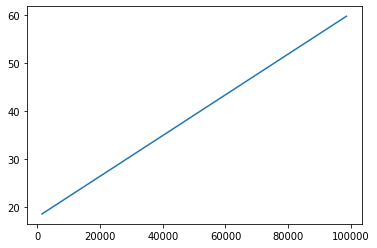

In [ ]:
## Because 'time' is the only variable that changes over time, the forecasts would be linear.

np.random.seed(1)
random_idx = np.random.randint(0, new_data2.shape[0], size=1 )
pr, cd, ct, st, ir, *_ = new_data2.iloc[random_idx].values[0]

temp_df = new_data2.query('PRUID == @pr & CDUID == @cd & conn_type == @ct & SACTYPE == @st & is_rural == @ir')

import matplotlib.pyplot as plt
plt.plot(temp_df['avg_u_mbps_lmm'])

In [11]:
# Generate timepoint labels:
years = list(range(2022, 2031))
quarters = ['1Q', '2Q', '3Q', '4Q']
year_quarters = []

for y in years:
    for q in quarters:
        year_quarters.append(str(y) + "-" + q)

lmm_df = pd.read_csv('arima_df.csv') # going to use the same format as for the arima forecasts
lmm_d_df = lmm_df.loc[:, ['PRUID', 'CDUID', 'conn_type', 'SACTYPE', 'is_rural']]

for yq in year_quarters:
    lmm_d_df[yq] = 0.0

lmm_u_df = lmm_d_df.copy()
lmm_u_df.head()

,PRUID,CDUID,conn_type,SACTYPE,is_rural,2022-1Q,2022-2Q,2022-3Q,2022-4Q,2023-1Q,...,2028-3Q,2028-4Q,2029-1Q,2029-2Q,2029-3Q,2029-4Q,2030-1Q,2030-2Q,2030-3Q,2030-4Q
0,10,1001,fixed,1,False,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,1001,fixed,1,True,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10,1001,mobile,1,False,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,1001,mobile,1,True,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,1001,fixed,3,False,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
from tqdm.auto import tqdm
for i in tqdm(range(0, lmm_u_df.shape[0])):
    pr, cu, ct, st, ir = lmm_u_df.iloc[i, 0:5]
    nd_cond = (new_data2.PRUID == pr) & (new_data2.CDUID == cu) & (new_data2.conn_type == ct) & (new_data2.SACTYPE == st) & (new_data2.is_rural == ir)
    temp_sub = new_data2.loc[nd_cond,].sort_values(by = "time").reset_index(drop = True)
    lmm_u_df.iloc[i, 5:] = temp_sub.avg_u_mbps_lmm

for j in tqdm(range(0, lmm_d_df.shape[0])):
    pr, cu, ct, st, ir = lmm_d_df.iloc[j, 0:5]
    nd_cond = (new_data2.PRUID == pr) & (new_data2.CDUID == cu) & (new_data2.conn_type == ct) & (new_data2.SACTYPE == st) & (new_data2.is_rural == ir)
    temp_sub = new_data2.loc[nd_cond,].sort_values(by = "time").reset_index(drop = True)
    lmm_d_df.iloc[j, 5:] = temp_sub.avg_u_mbps_lmm

lmm_d_df.to_csv('lmm_d_forecasted.csv', index=False)
lmm_u_df.to_csv('lmm_u_forecasted.csv', index=False)

  0%|          | 0/2771 [00:00<?, ?it/s]

  0%|          | 0/2771 [00:00<?, ?it/s]

In [49]:
lmm_u_df

,PRUID,CDUID,conn_type,SACTYPE,is_rural,2022-1Q,2022-2Q,2022-3Q,2022-4Q,2023-1Q,...,2028-3Q,2028-4Q,2029-1Q,2029-2Q,2029-3Q,2029-4Q,2030-1Q,2030-2Q,2030-3Q,2030-4Q
0,10,1001,fixed,1,False,59.329065,60.507682,61.686298,62.864915,64.043531,...,89.973094,91.151710,92.330327,93.508943,94.687560,95.866176,97.044793,98.223409,99.402026,100.580642
1,10,1001,fixed,1,True,49.852151,51.030767,52.209384,53.388000,54.566617,...,80.496179,81.674796,82.853412,84.032029,85.210645,86.389262,87.567878,88.746495,89.925111,91.103728
2,10,1001,mobile,1,False,40.204965,41.383581,42.562198,43.740814,44.919431,...,70.848994,72.027610,73.206227,74.384843,75.563460,76.742076,77.920693,79.099309,80.277926,81.456542
3,10,1001,mobile,1,True,30.728050,31.906667,33.085283,34.263900,35.442516,...,61.372079,62.550696,63.729312,64.907929,66.086545,67.265162,68.443778,69.622395,70.801011,71.979628
4,10,1001,fixed,3,False,54.852867,56.031483,57.210100,58.388716,59.567333,...,85.496896,86.675512,87.854129,89.032745,90.211362,91.389978,92.568595,93.747211,94.925828,96.104444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2766,62,6204,mobile,8,True,2.478615,3.657231,4.835848,6.014464,7.193081,...,33.122643,34.301260,35.479876,36.658493,37.837109,39.015726,40.194342,41.372959,42.551575,43.730192
2767,62,6205,fixed,8,False,33.589271,34.767887,35.946504,37.125120,38.303737,...,64.233299,65.411916,66.590532,67.769149,68.947765,70.126382,71.304998,72.483615,73.662231,74.840848
2768,62,6205,mobile,8,False,14.465170,15.643787,16.822403,18.001020,19.179636,...,45.109199,46.287816,47.466432,48.645049,49.823665,51.002282,52.180898,53.359515,54.538131,55.716748
2769,62,6205,mobile,8,True,4.988256,6.166872,7.345489,8.524105,9.702722,...,35.632285,36.810901,37.989518,39.168134,40.346751,41.525367,42.703984,43.882600,45.061217,46.239833
